# Block 1: Environment Setup & Imports
 

In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os

# Check GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2026-02-02 11:39:16.542166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770032356.715296      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770032356.767918      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770032357.190401      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770032357.190456      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770032357.190459      23 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Block 2: Data Loading & Preprocessing


In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to categorical
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 10)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 10)


# Block 3: Data Augmentation Setup


In [3]:
# Data augmentation for training (enhanced for deeper model)
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# No augmentation for validation/test
test_datagen = ImageDataGenerator()

# Create data generators
batch_size = 128
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
test_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size, shuffle=False)

# Block 4: Bottleneck Block Implementation


In [4]:
def bottleneck_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None):
    """
    A bottleneck block for ResNet-50/101/152
    
    The bottleneck architecture uses 1x1, 3x3, 1x1 convolutions to reduce
    computational cost while maintaining representational power.
    
    Args:
        x: input tensor
        filters: number of filters in the bottleneck layer (3x3 conv)
        kernel_size: kernel size for middle convolution (default 3)
        stride: stride for middle convolution
        conv_shortcut: use convolution for shortcut (True) or identity (False)
        name: block label
    """
    bn_axis = 3  # Channel axis for 'channels_last'
    
    if conv_shortcut:
        shortcut = layers.Conv2D(4 * filters, 1, strides=stride, name=name + '_0_conv')(x)
        shortcut = layers.BatchNormalization(axis=bn_axis, name=name + '_0_bn')(shortcut)
    else:
        shortcut = x
    
    # First 1x1 convolution (dimensionality reduction)
    x = layers.Conv2D(filters, 1, strides=1, use_bias=False, name=name + '_1_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)
    
    # Second 3x3 convolution (main processing)
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                      use_bias=False, name=name + '_2_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)
    
    # Third 1x1 convolution (dimensionality expansion)
    x = layers.Conv2D(4 * filters, 1, use_bias=False, name=name + '_3_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=name + '_3_bn')(x)
    
    # Add shortcut connection
    x = layers.Add(name=name + '_add')([shortcut, x])
    x = layers.Activation('relu', name=name + '_out')(x)
    
    return x

# Block 5: ResNet-50 Architecture


In [5]:
def ResNet50(input_shape=(32, 32, 3), num_classes=10):
    """
    ResNet-50 architecture adapted for CIFAR-10
    
    Architecture using Bottleneck blocks:
    - conv1: 1 layer
    - conv2_x: 3 bottleneck blocks (64 filters → 256 output)
    - conv3_x: 4 bottleneck blocks (128 filters → 512 output)
    - conv4_x: 6 bottleneck blocks (256 filters → 1024 output)
    - conv5_x: 3 bottleneck blocks (512 filters → 2048 output)
    Total: 50 layers
    
    Note: Each bottleneck block has 3 convolutions, so counting:
    1 (conv1) + 3*3 + 4*3 + 6*3 + 3*3 + 1 (fc) = 50 layers
    """
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolution (adapted for CIFAR-10)
    x = layers.Conv2D(64, 3, strides=1, padding='same', use_bias=False, name='conv1_conv')(inputs)
    x = layers.BatchNormalization(axis=3, name='conv1_bn')(x)
    x = layers.Activation('relu', name='conv1_relu')(x)
    # Note: No MaxPooling for CIFAR-10 due to small image size
    
    # Stage 1 (conv2_x): 3 bottleneck blocks with 64 filters (output: 256 channels)
    x = bottleneck_block(x, 64, conv_shortcut=True, name='conv2_block1')
    x = bottleneck_block(x, 64, conv_shortcut=False, name='conv2_block2')
    x = bottleneck_block(x, 64, conv_shortcut=False, name='conv2_block3')
    
    # Stage 2 (conv3_x): 4 bottleneck blocks with 128 filters (output: 512 channels)
    x = bottleneck_block(x, 128, stride=2, conv_shortcut=True, name='conv3_block1')
    x = bottleneck_block(x, 128, conv_shortcut=False, name='conv3_block2')
    x = bottleneck_block(x, 128, conv_shortcut=False, name='conv3_block3')
    x = bottleneck_block(x, 128, conv_shortcut=False, name='conv3_block4')
    
    # Stage 3 (conv4_x): 6 bottleneck blocks with 256 filters (output: 1024 channels)
    x = bottleneck_block(x, 256, stride=2, conv_shortcut=True, name='conv4_block1')
    x = bottleneck_block(x, 256, conv_shortcut=False, name='conv4_block2')
    x = bottleneck_block(x, 256, conv_shortcut=False, name='conv4_block3')
    x = bottleneck_block(x, 256, conv_shortcut=False, name='conv4_block4')
    x = bottleneck_block(x, 256, conv_shortcut=False, name='conv4_block5')
    x = bottleneck_block(x, 256, conv_shortcut=False, name='conv4_block6')
    
    # Stage 4 (conv5_x): 3 bottleneck blocks with 512 filters (output: 2048 channels)
    x = bottleneck_block(x, 512, stride=2, conv_shortcut=True, name='conv5_block1')
    x = bottleneck_block(x, 512, conv_shortcut=False, name='conv5_block2')
    x = bottleneck_block(x, 512, conv_shortcut=False, name='conv5_block3')
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    
    # Optional: Add dropout for regularization
    x = layers.Dropout(0.5, name='dropout')(x)
    
    # Fully connected layer
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    
    # Create model
    model = models.Model(inputs, outputs, name='resnet50')
    
    return model

# Block 6: Model Creation & Summary


In [6]:
# Create the model
model = ResNet50(input_shape=(32, 32, 3), num_classes=10)

# Display model summary
model.summary()

# Count total parameters
total_params = model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
non_trainable_params = sum([tf.size(w).numpy() for w in model.non_trainable_weights])

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable_params:,}")

I0000 00:00:1770032380.098728      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      1,728 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,096 │ conv1_relu[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ conv1_relu[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,384 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_add    │ (None, 32, 32,    │          0 │ conv2_block1_0_b… │
│ (Add)               │ 256)              │            │ conv2_block1_3_b… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 32, 32,    │          0 │ conv2_block1_add… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 32, 32,    │     16,384 │ conv2_block1_out

 Total params: 23,577,802 (89.94 MB)

 Trainable params: 23,524,682 (89.74 MB)

 Non-trainable params: 53,120 (207.50 KB)


Total parameters: 23,577,802
Trainable parameters: 23,524,682
Non-trainable parameters: 53,120


# Block 7: Compile Model with Label Smoothing


In [7]:
# Label smoothing loss for better generalization
class LabelSmoothingCategoricalCrossentropy(keras.losses.Loss):
    def __init__(self, smoothing=0.1, **kwargs):
        super().__init__(**kwargs)
        self.smoothing = smoothing
    
    def call(self, y_true, y_pred):
        # Apply label smoothing
        num_classes = tf.cast(tf.shape(y_true)[-1], y_pred.dtype)
        y_true = y_true * (1.0 - self.smoothing) + (self.smoothing / num_classes)
        return keras.losses.categorical_crossentropy(y_true, y_pred)

# Define optimizer
initial_learning_rate = 0.1

# Compile model with label smoothing
model.compile(
    optimizer=optimizers.SGD(learning_rate=initial_learning_rate, momentum=0.9, nesterov=True),
    loss=LabelSmoothingCategoricalCrossentropy(smoothing=0.1),
    metrics=['accuracy']
)

print("Model compiled successfully with label smoothing!")

Model compiled successfully with label smoothing!


# Block 8: Callbacks Setup with Cosine Annealing


In [8]:
# Create directory for saving models
os.makedirs('./models', exist_ok=True)

# Custom learning rate schedule - Cosine Annealing
class CosineAnnealingScheduler(keras.callbacks.Callback):
    def __init__(self, T_max, eta_min=0, eta_max=0.1):
        super().__init__()
        self.T_max = T_max
        self.eta_min = eta_min
        self.eta_max = eta_max
        
    def on_epoch_begin(self, epoch, logs=None):
        lr = self.eta_min + (self.eta_max - self.eta_min) * \
             (1 + np.cos(np.pi * epoch / self.T_max)) / 2
        # Correct way to set learning rate in newer Keras versions
        self.model.optimizer.learning_rate.assign(lr)
        print(f'\nEpoch {epoch+1}: Learning rate is {lr:.6f}')

# Model checkpoint - save best model
checkpoint = ModelCheckpoint(
    './models/resnet50_cifar10_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Cosine annealing learning rate
cosine_scheduler = CosineAnnealingScheduler(T_max=150, eta_min=1e-5, eta_max=0.1)

# Reduce learning rate on plateau (backup)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-6,
    verbose=1
)

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

callbacks = [checkpoint, cosine_scheduler, early_stop]

print("Callbacks configured successfully!")

Callbacks configured successfully!


# Block 9: Training


In [9]:
# Training parameters
epochs = 150  # More epochs for deeper model
steps_per_epoch = len(x_train) // batch_size

# Train the model
print("Starting training...")
print(f"Batch size: {batch_size}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Total epochs: {epochs}")

history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=(x_test, y_test),
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Starting training...
Batch size: 128
Steps per epoch: 390
Total epochs: 150

Epoch 1: Learning rate is 0.100000
Epoch 1/150


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1770032399.056225      65 service.cc:152] XLA service 0x799370002200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770032399.056275      65 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1770032401.568130      65 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1770032423.586354      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.1457 - loss: 5.0165
Epoch 1: val_accuracy improved from -inf to 0.20040, saving model to ./models/resnet50_cifar10_best.keras
390/390 ━━━━━━━━━━━━━━━━━━━━ 148s 276ms/step - accuracy: 0.1458 - loss: 5.0120 - val_accuracy: 0.2004 - val_loss: 2.1815

Epoch 2: Learning rate is 0.099989
Epoch 2/150
  1/390 ━━━━━━━━━━━━━━━━━━━━ 1:14 193ms/step - accuracy: 0.2266 - loss: 3.5737

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.20040
390/390 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.2266 - loss: 3.5737 - val_accuracy: 0.1975 - val_loss: 2.1812

Epoch 3: Learning rate is 0.099956
Epoch 3/150
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.2660 - loss: 2.3415
Epoch 3: val_accuracy improved from 0.20040 to 0.28110, saving model to ./models/resnet50_cifar10_best.keras
390/390 ━━━━━━━━━━━━━━━━━━━━ 79s 204ms/step - accuracy: 0.2661 - loss: 2.3413 - val_accuracy: 0.2811 - val_loss: 2.0897

Epoch 4: Learning rate is 0.099901
Epoch 4/150
  1/390 ━━━━━━━━━━━━━━━━━━━━ 1:11 183ms/step - accuracy: 0.2891 - loss: 2.0816
Epoch 4: val_accuracy did not improve from 0.28110
390/390 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.2891 - loss: 2.0816 - val_accuracy: 0.2776 - val_loss: 2.1104

Epoch 5: Learning rate is 0.099825
Epoch 5/150
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.3477 - loss: 2.0750
Epoch 5: val_accuracy improved from 0.28110 to 0.41020,

# Block 10: Training History Visualization


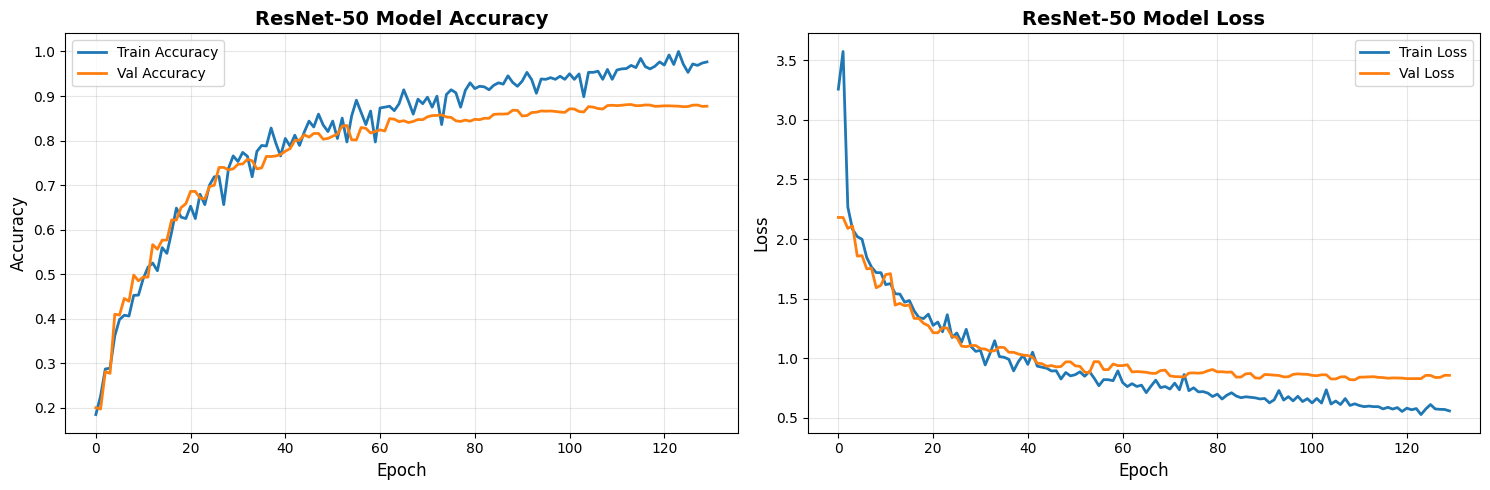

In [10]:
# Plot training history
def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0].set_title('ResNet-50 Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Loss plot
    axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[1].set_title('ResNet-50 Model Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('resnet50_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_history(history)

# Block 11: Model Evaluation


In [11]:
# Evaluate on test set
print("Evaluating model on test set...")
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Get predictions
print("Generating predictions...")
predictions = model.predict(x_test, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

Evaluating model on test set...
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8826 - loss: 0.8129

Test Loss: 0.8196
Test Accuracy: 0.8793 (87.93%)
Generating predictions...
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step


# Block 12: Confusion Matrix & Classification Report


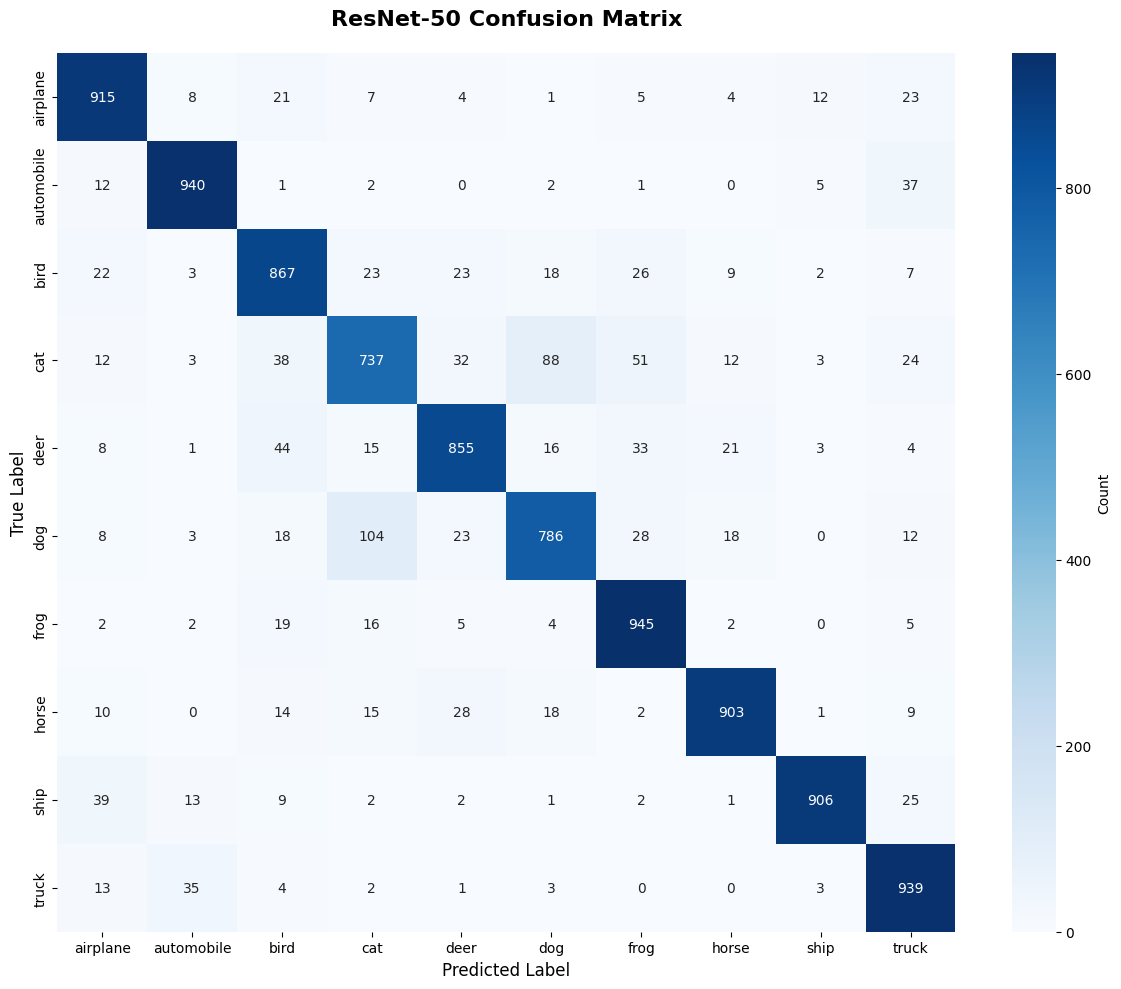


Classification Report:
              precision    recall  f1-score   support

    airplane       0.88      0.92      0.90      1000
  automobile       0.93      0.94      0.94      1000
        bird       0.84      0.87      0.85      1000
         cat       0.80      0.74      0.77      1000
        deer       0.88      0.85      0.87      1000
         dog       0.84      0.79      0.81      1000
        frog       0.86      0.94      0.90      1000
       horse       0.93      0.90      0.92      1000
        ship       0.97      0.91      0.94      1000
       truck       0.87      0.94      0.90      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('ResNet-50 Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('resnet50_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification report
print("\nClassification Report:")
print("=" * 70)
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Block 13: Visualize Predictions


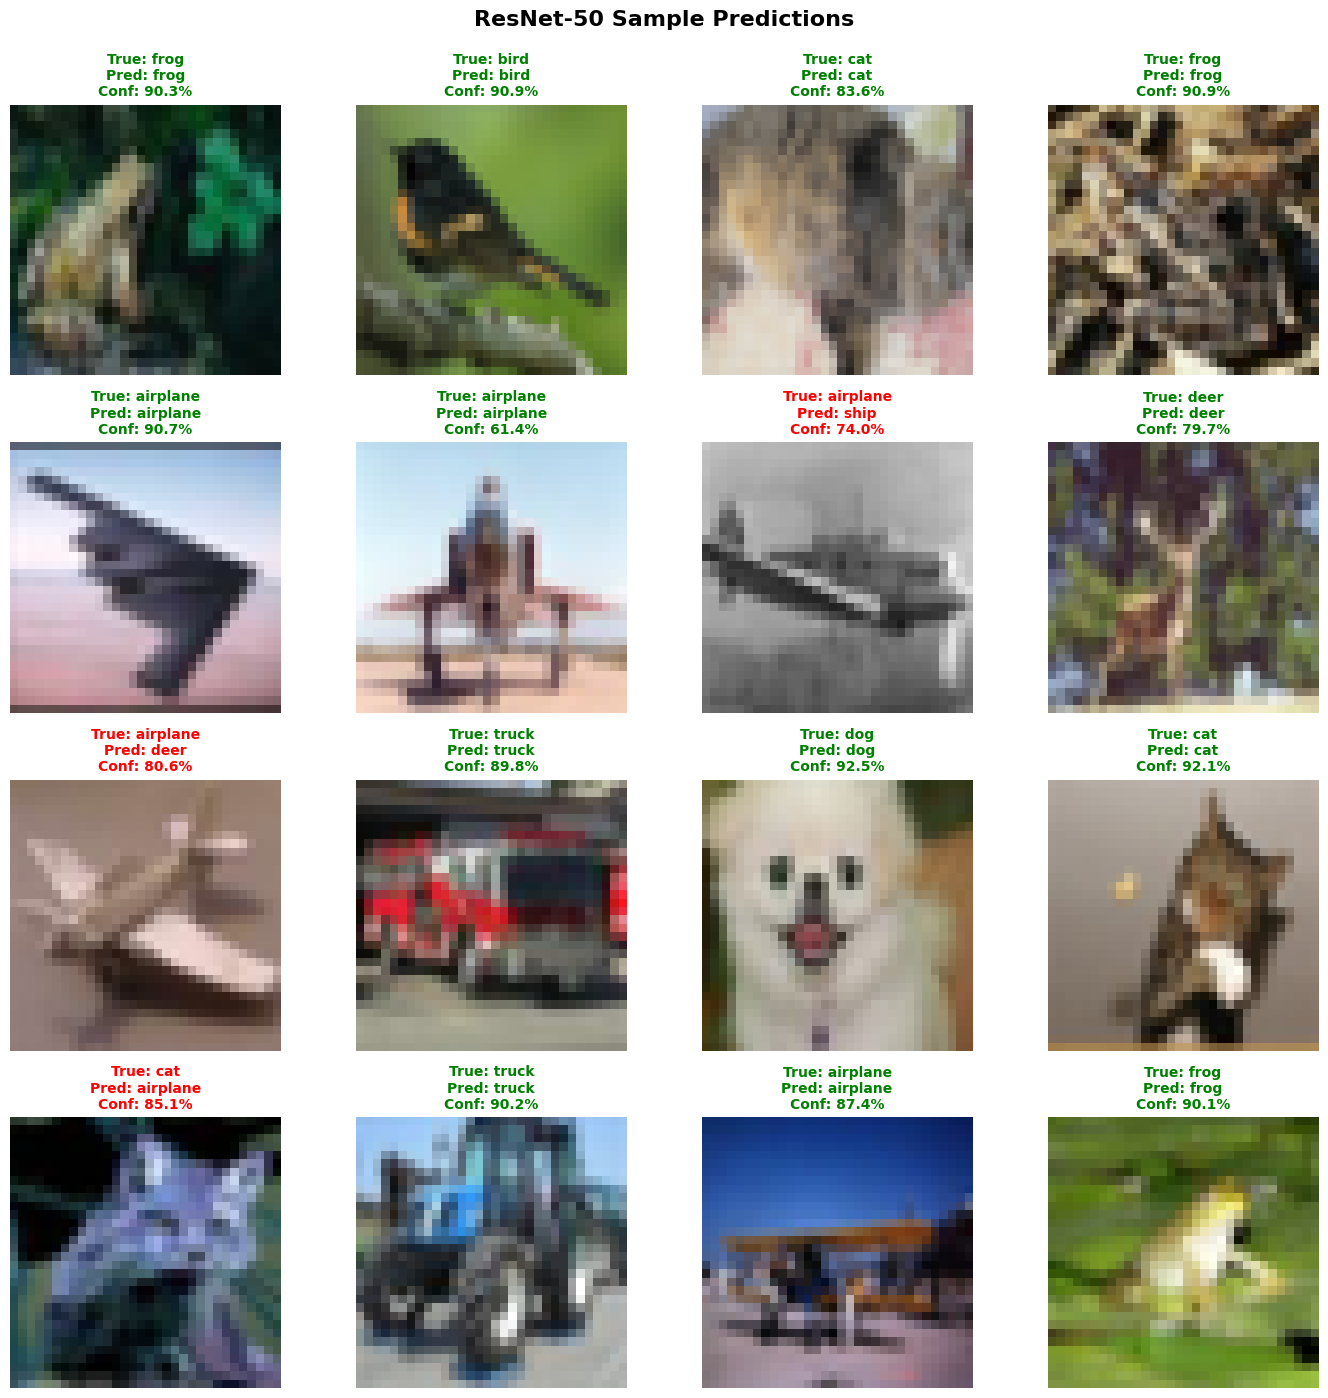

In [13]:
# Visualize predictions with confidence scores
def visualize_predictions(num_images=16):
    indices = np.random.choice(len(x_test), num_images, replace=False)
    
    fig, axes = plt.subplots(4, 4, figsize=(14, 14))
    axes = axes.ravel()
    
    for i, idx in enumerate(indices):
        axes[i].imshow(x_test[idx])
        true_label = class_names[true_classes[idx]]
        pred_label = class_names[predicted_classes[idx]]
        confidence = predictions[idx][predicted_classes[idx]] * 100
        
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%', 
                         color=color, fontsize=10, fontweight='bold')
        axes[i].axis('off')
    
    plt.suptitle('ResNet-50 Sample Predictions', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('resnet50_predictions_sample.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_predictions()

# Block 14: Top-K Accuracy Analysis


In [14]:
# Calculate top-k accuracy
def calculate_topk_accuracy(y_true, y_pred, k=3):
    """Calculate top-k accuracy"""
    top_k_pred = np.argsort(y_pred, axis=1)[:, -k:]
    correct = 0
    for i, true_label in enumerate(y_true):
        if true_label in top_k_pred[i]:
            correct += 1
    return correct / len(y_true)

top1_acc = test_accuracy
top3_acc = calculate_topk_accuracy(true_classes, predictions, k=3)
top5_acc = calculate_topk_accuracy(true_classes, predictions, k=5)

print("\nTop-K Accuracy Analysis:")
print("=" * 40)
print(f"Top-1 Accuracy: {top1_acc*100:.2f}%")
print(f"Top-3 Accuracy: {top3_acc*100:.2f}%")
print(f"Top-5 Accuracy: {top5_acc*100:.2f}%")


Top-K Accuracy Analysis:
Top-1 Accuracy: 87.93%
Top-3 Accuracy: 97.70%
Top-5 Accuracy: 99.15%


# Block 15: Save Final Model


In [15]:
# Save the complete model in native Keras format
model.save('./models/resnet50_cifar10_final.keras')
print("Final model saved in Keras format!")

# Save model architecture as JSON
model_json = model.to_json()
with open('./models/resnet50_architecture.json', 'w') as json_file:
    json_file.write(model_json)
print("Model architecture saved!")

# Save weights separately
model.save_weights('./models/resnet50.weights.h5')
print("Model weights saved!")

print("\nModel files created:")
print("  - resnet50_cifar10_final.keras (complete model)")
print("  - resnet50.weights.h5 (weights only)")
print("  - resnet50_architecture.json (architecture)")

Final model saved in Keras format!
Model architecture saved!
Model weights saved!

Model files created:
  - resnet50_cifar10_final.keras (complete model)
  - resnet50.weights.h5 (weights only)
  - resnet50_architecture.json (architecture)


# Block 16: Per-Class Accuracy Analysis


In [16]:
# Calculate per-class accuracy with additional metrics
from collections import defaultdict

class_correct = defaultdict(int)
class_total = defaultdict(int)
class_confidence = defaultdict(list)

for i in range(len(true_classes)):
    label = true_classes[i]
    class_total[label] += 1
    confidence = predictions[i][predicted_classes[i]]
    class_confidence[label].append(confidence)
    
    if predicted_classes[i] == label:
        class_correct[label] += 1

# Print detailed per-class statistics
print("\nDetailed Per-Class Analysis (ResNet-50):")
print("=" * 70)
print(f"{'Class':<12} {'Accuracy':<12} {'Avg Confidence':<18} {'Samples':<10}")
print("-" * 70)

for i in range(10):
    accuracy = 100 * class_correct[i] / class_total[i]
    avg_conf = np.mean(class_confidence[i]) * 100
    print(f"{class_names[i]:<12} {accuracy:>6.2f}%      {avg_conf:>6.2f}%            {class_total[i]:>6}")

print("=" * 70)


Detailed Per-Class Analysis (ResNet-50):
Class        Accuracy     Avg Confidence     Samples   
----------------------------------------------------------------------
airplane      91.50%       85.86%              1000
automobile    94.00%       89.47%              1000
bird          86.70%       84.08%              1000
cat           73.70%       79.41%              1000
deer          85.50%       84.70%              1000
dog           78.60%       82.20%              1000
frog          94.50%       87.94%              1000
horse         90.30%       85.39%              1000
ship          90.60%       87.55%              1000
truck         93.90%       88.14%              1000
